In [1]:
import settings
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np

from lasairmod import LasairError, lasair_client as lasair
import sys, time
import json
import scipy
from scipy import stats 
from sympy import *

/Users/eleanorgallay/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Defining difference -> apparent magnitude function and associated error propagation function

In [2]:
def diff_to_app_mag(ref_mag, alert_mag, sign): 
    """ Function converts from difference magnitudes to apparent magnitudes. 
    Inputs are
        1) ref_mag: Magnitude of reference source (float or int)
        2) alert_mag: Difference magnitude of alert (float or int)
        3) sign: Sign of the difference magnitude (str)
                t = positive difference magnitude = brightening
                f = negative difference magnitude = faintening
                
    Returns apparent magnitude (app_mag) as type float
    """
    if sign =='t': 
        app_mag = ((-2.5)*np.log10((10**((-.4)*ref_mag)) + (10**((-.4)*alert_mag))))
    else:
        app_mag = ((-2.5)*np.log10((10**((-.4)*ref_mag)) - (10**((-.4)*alert_mag)))) 
    
    return app_mag

In [3]:
def app_mag_err_prop(ref_mag, alert_mag, sign, ref_err, alert_err): 
    """ Function propagates error when converting from difference magnitudes to apparent magnitudes. 
    Inputs are
        1) ref_mag: Magnitude of reference source (float or int)
        2) alert_mag: Difference magnitude of alert (float or int)
        3) sign: Sign of the difference magnitude (str)
                t = positive difference magnitude = brightening
                f = negative difference magnitude = faintening
        4) ref_err: 1-sigma uncertainty in reference magnitude (float or int)
        5) alert_err: 1-sigma uncertainty in alert magnitude (float or int)
                
    Returns apparent magnitude error (app_err) as type float
    """
    
    r, a= symbols('r a', real=True) # Defines variables r (reference mag) and a (alert mag)
    
    if sign =='t': 
        f = ((-2.5)*log(((10**((-.4)*r)) + (10**((-.4)*a))),10))    # Defines apparent magnitude function f 
                                                                    # for positive difference magnitides
    else:
        f = ((-2.5)*log(((10**((-.4)*r)) - (10**((-.4)*a))),10))    # Defines apparent magnitude function f 
                                                                    # for negative difference magnitides 
    
    d_ref = diff(f, r).subs([(a, alert_mag), (r, ref_mag)])         # Partial derivative of f with respect to r
    d_alert = diff(f, a).subs([(a, alert_mag), (r, ref_mag)])       # Partial derivative of f with respect to a
    
    app_err = float(sqrt((((d_ref)**2)*((ref_err)**2))+(((d_alert)**2)*((alert_err)**2))))   # Error propagation formula
    
    return app_err

### Lasair API query for objects that pass Disappearing Stars v4 filter with most recent alerts in the past 3 days

In [4]:
jdnow = str(Time.now().jd)

selected = '*'


tables = 'objects,sherlock_classifications'


conditions = """
objects.objectId=sherlock_classifications.objectId
AND (objects.sgscore1 > 0.9)
AND (sherlock_classifications.classification != "SN")
AND (sherlock_classifications.classification != "NT")
AND (sherlock_classifications.classification != "AGN")
AND (objects.ncand > 5)
AND (objects.ncand < 20)
AND (sherlock_classifications.catalogue_table_name LIKE "%gaia%")
AND (objects.objectId LIKE "ZTF24%")
AND sherlock_classifications.separationArcsec < 0.5
AND ((objects.sgmag1 < 16)
   OR (objects.srmag1 < 16))
AND ((objects.mag_r28 < objects.mag_r08 < objects.mag_r02)
   OR (objects.mag_g28 < objects.mag_g08 < objects.mag_g02))
AND ISNULL(objects.ncandgp)
AND ("""+jdnow+"""- objects.jdmax) < 3

"""

L = lasair(settings.API_TOKEN, endpoint = "https://lasair-ztf.lsst.ac.uk/api")

try:
    v4 = L.query(selected, tables, conditions)
except LasairError as e:
    print(e)

### Plotting light curves

/var/folders/39/_j5zssj14k9d0742tpg79j380000gn/T/ipykernel_28244/1974644963.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


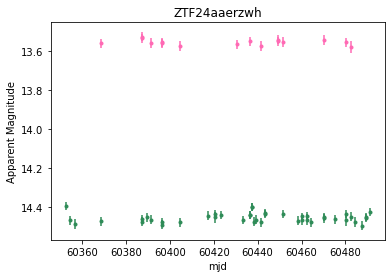

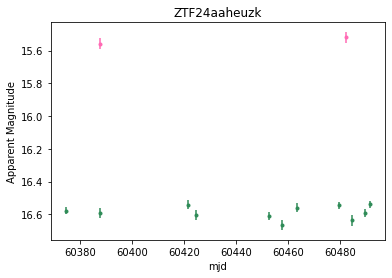

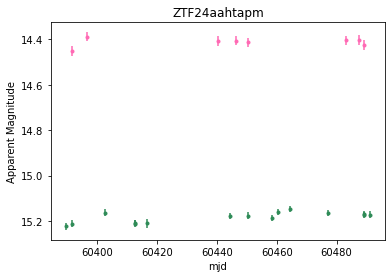

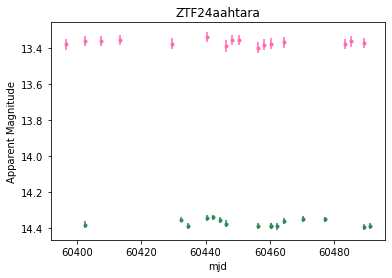

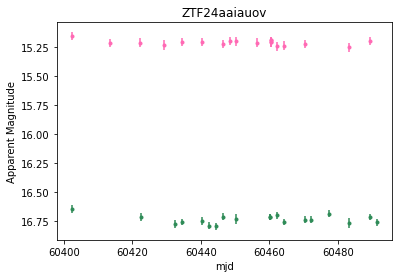

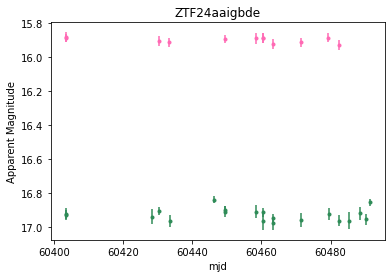

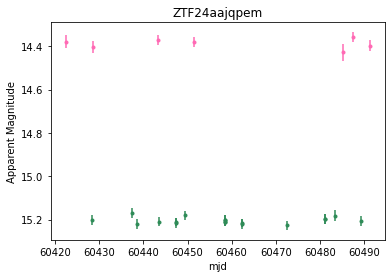

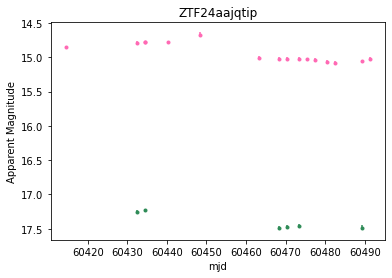

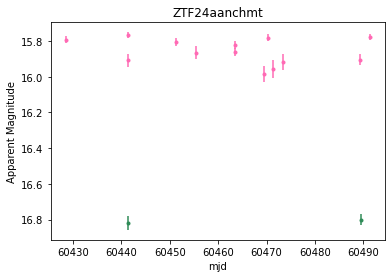

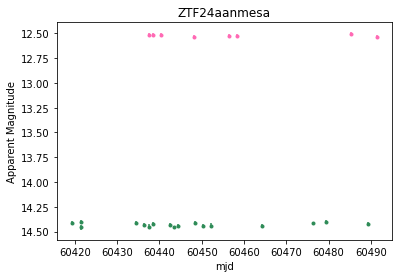

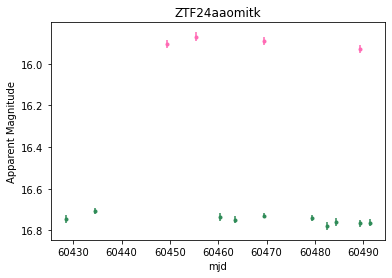

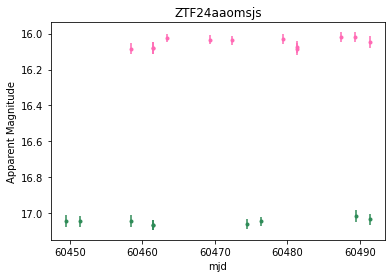

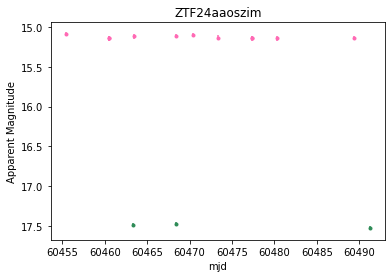

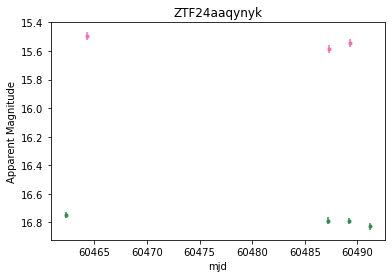

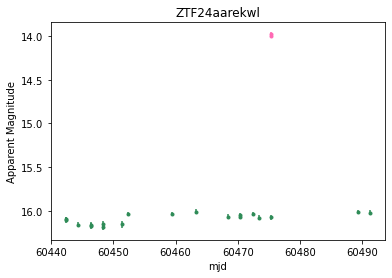

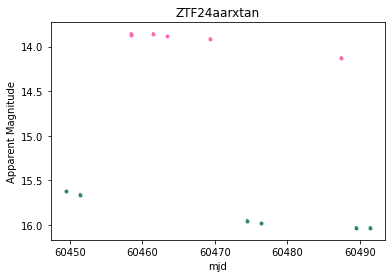

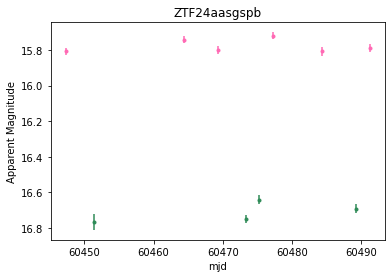

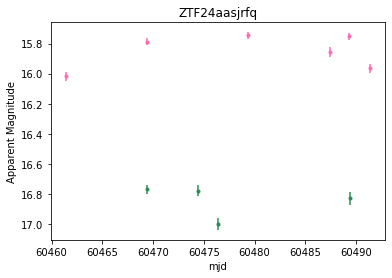

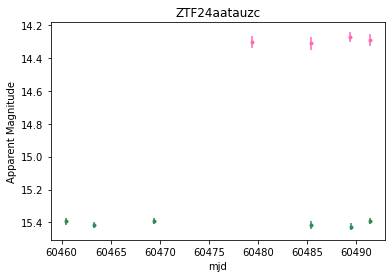

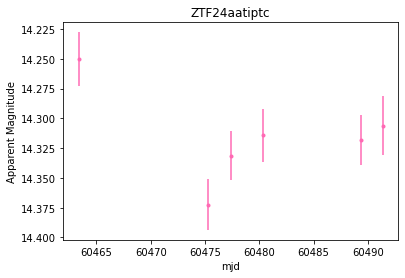

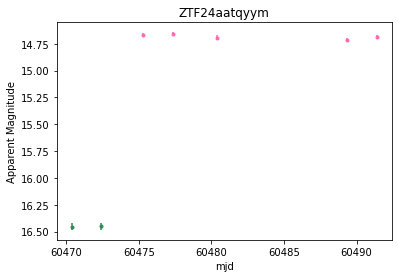

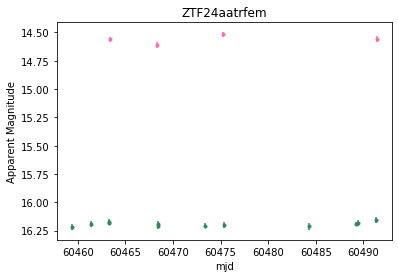

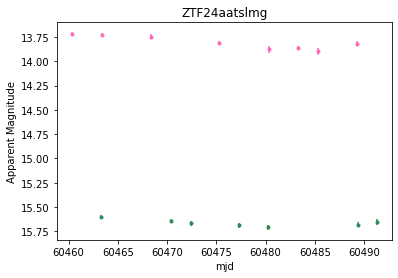

In [5]:
Dips= L.objects([row['objectId'] for row in v4])

lc = {}
cols = {1:'seagreen',2:'hotpink', 3: 'indigo'}

for obj in Dips:
    try:
        lc[obj['objectId']] = {'candidates': obj['candidates']}
    except TypeError:
        print('no')

    plt.figure()
    plt.subplot(111)
    
    for i in lc[obj['objectId']]['candidates']:

        if 'isdiffpos' in i:
            app_mag = diff_to_app_mag(i['magnr'], i['magpsf'], i['isdiffpos'])
            app_err = app_mag_err_prop(i['magnr'], i['magpsf'], i['isdiffpos'], i['sigmagnr'], i['sigmapsf'])

            plt.errorbar(i['mjd'], app_mag, yerr= app_err, fmt = '.', color=cols[i['fid']])
    
    plt.gca().invert_yaxis()
    plt.ylabel('Apparent Magnitude')
    plt.xlabel('mjd')
    plt.title(obj['objectId'])
    

### Attempting to bin the light curves by daily average apparent magnitude

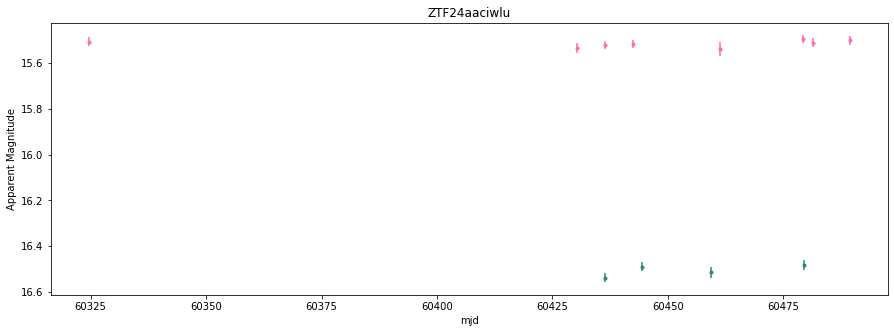

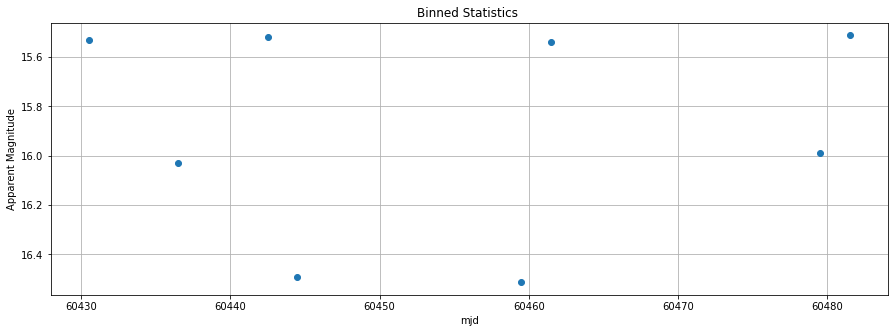

[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan   

In [44]:
aaciwlu = L.objects(['ZTF24aaciwlu'])
testlc = {}
cols = {1:'seagreen',2:'hotpink', 3: 'indigo'}

for obj in aaciwlu:
    try:
        testlc[obj['objectId']] = {'candidates': obj['candidates']}
    except TypeError:
        print('no')

    plt.figure(figsize = (15, 5))
    plt.subplot(111)
    
    for i in testlc[obj['objectId']]['candidates']:
        if 'isdiffpos' in i:
            app_mag = diff_to_app_mag(i['magnr'], i['magpsf'], i['isdiffpos'])
            app_err = app_mag_err_prop(i['magnr'], i['magpsf'], i['isdiffpos'], i['sigmagnr'], i['sigmapsf'])

            plt.errorbar(i['mjd'], app_mag, yerr= app_err, fmt = '.', color=cols[i['fid']])
    
    plt.gca().invert_yaxis()
    plt.ylabel('Apparent Magnitude')
    plt.xlabel('mjd')
    plt.title(obj['objectId'])
        
    mags = []
    mjds = []
    
    for i in testlc[obj['objectId']]['candidates']: 
            if 'isdiffpos' in i:
                app_mag = diff_to_app_mag(i['magnr'], i['magpsf'], i['isdiffpos'])
                mags.append(app_mag)
                mjds.append(i['mjd'])
                
    bin_means, bin_edges, _ = stats.binned_statistic(np.array(mjds), np.array(mags), bins = (round(np.max(mjds) - np.min(mjds)) -1) , range= (round(np.min(mjds)), round(np.max(mjds))))
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    plt.figure(figsize=(15, 5))
    plt.errorbar(bin_centers, bin_means, yerr=None, linestyle='-', marker='o')
    plt.xlabel('mjd')
    plt.ylabel('Apparent Magnitude')
    plt.title('Binned Statistics ')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()
    print(bin_means)

#     bin = stats.binned_statistic(np.array(mjds), np.array(mags), bins = (round(np.max(mjds) - np.min(mjds)) -1) , range= (round(np.min(mjds)), round(np.max(mjds))))
#     print(np.size(bin[0]))
#     print(np.size(bin[1]))
#     #plt.plot(bin[0], bin[1])
#     print(bin[0])
#     print(bin[1])
#     print(round(np.max(mjds) - np.min(mjds)) -1)
#     plt.figure(figsize = (15,5))
#     plt.subplot(111)
#     bin_mjd = []
#     bin_mag = []
#     for j in bin[0]:
#         for k in bin[1]:
#             if j != nan:
#                 bin_mjd.append(k)
#                 bin_mag.append(j)
#     print(bin_mjd)
#     print(bin_mag)